# Setting Pyspark

In [1]:
import findspark
import matplotlib.pyplot as plt
import seaborn as sns

from configs.config import DATA_SOURCE_DIR, PROJECT_DIR
from pyspark.sql import SparkSession
from train.transforms.utils import *
from train.transforms.splitting import stratified_splitting
from train.transforms.outliers import log_transformation
from train.transforms.categorical_data import * 
from train.transforms.categorical_data import *
from train.transforms.correlation import *

In [2]:
findspark.init()
findspark.find()

spark= SparkSession \
       .builder \
       .appName("Feature engineering 1") \
       .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/24 23:04:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv(str(DATA_SOURCE_DIR),header=True,escape="\"")
df_pandas = df.toPandas()

# Stratified Splitting

In [4]:
train_df, test_df, val_df = stratified_splitting(
    df_pandas, train_size=0.8, test_size=0.1, val_size=0.1, random_state=42
)

Confirm the proportion of class

In [5]:
def test_stratified_sampling(source_df, 
                             train_df,
                             test_df,
                             val_df
                            ):
    source_df_class_proportion = source_df['loan_status'].value_counts()[0] / source_df['loan_status'].value_counts()[1]
    train_df_class_proportion = train_df['loan_status'].value_counts()[0] / train_df['loan_status'].value_counts()[1]
    val_df_class_proportion = val_df['loan_status'].value_counts()[0] / val_df['loan_status'].value_counts()[1]
    test_df_class_proportion = test_df['loan_status'].value_counts()[0] / test_df['loan_status'].value_counts()[1]

    if source_df_class_proportion == train_df_class_proportion == val_df_class_proportion == test_df_class_proportion:
        print("The proportion of class in each set are the same")

In [6]:
test_stratified_sampling(
    df_pandas, train_df, test_df, val_df
)

The proportion of class in each set are the same


/var/folders/13/jltvwky966g5t57g1b1zpn5h0000gn/T/ipykernel_22904/1785067673.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  source_df_class_proportion = source_df['loan_status'].value_counts()[0] / source_df['loan_status'].value_counts()[1]
/var/folders/13/jltvwky966g5t57g1b1zpn5h0000gn/T/ipykernel_22904/1785067673.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  source_df_class_proportion = source_df['loan_status'].value_counts()[0] / source_df['loan_status'].value_counts()[1]
/var/folders/13/jltvwky966g5t57g1b1zpn5h0000gn/T/ipykernel_22904/1785067673.py:7: FutureWarning: Series.__getitem__ treating keys as p

Convert back to pyspark dataframe

In [7]:
train_spark_df = spark.createDataFrame(train_df)
test_spark_df = spark.createDataFrame(test_df)
val_spark_df = spark.createDataFrame(val_df)

# Handle outliers
- Performing log transformation on some feature columns to reduce skewness

In [8]:
train_spark_df = log_transformation(train_spark_df, 
                    target_cols=["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_percent_income", "cb_person_cred_hist_length"])
test_spark_df = log_transformation(test_spark_df, 
                    target_cols=["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_percent_income", "cb_person_cred_hist_length"])
val_spark_df = log_transformation(val_spark_df, 
                    target_cols=["person_age", "person_income", "person_emp_exp", "loan_amnt", "loan_percent_income", "cb_person_cred_hist_length"])

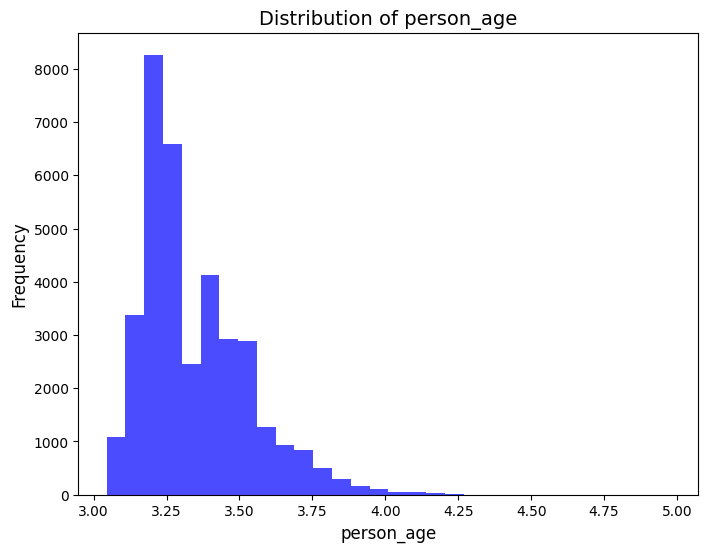

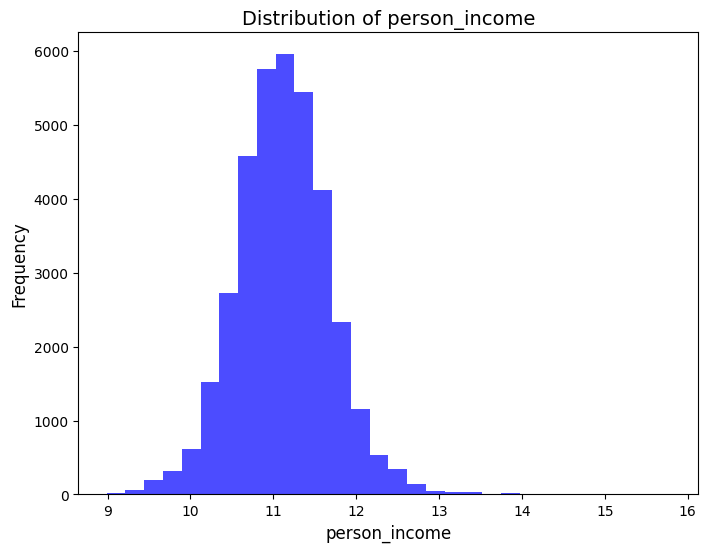

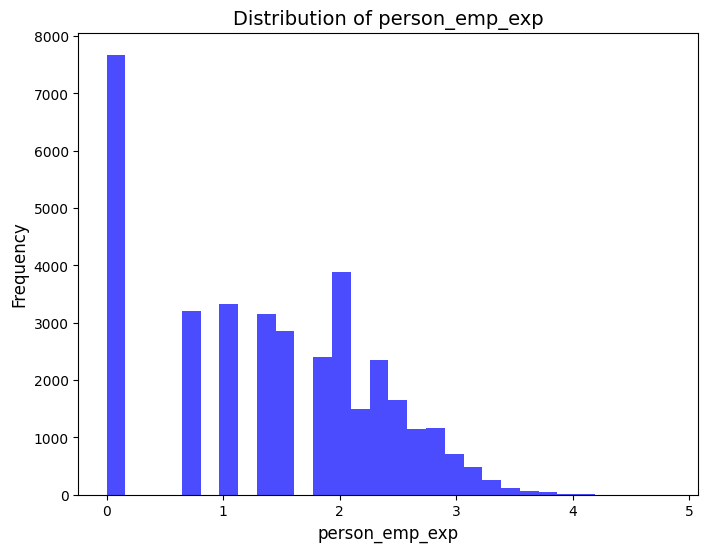

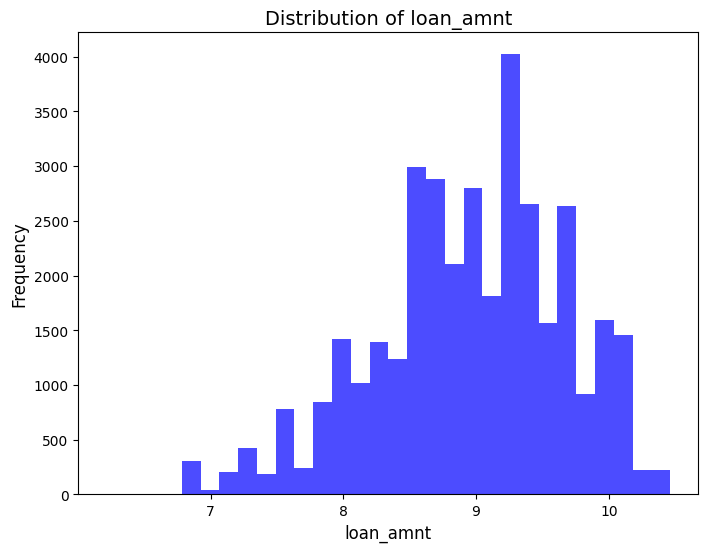

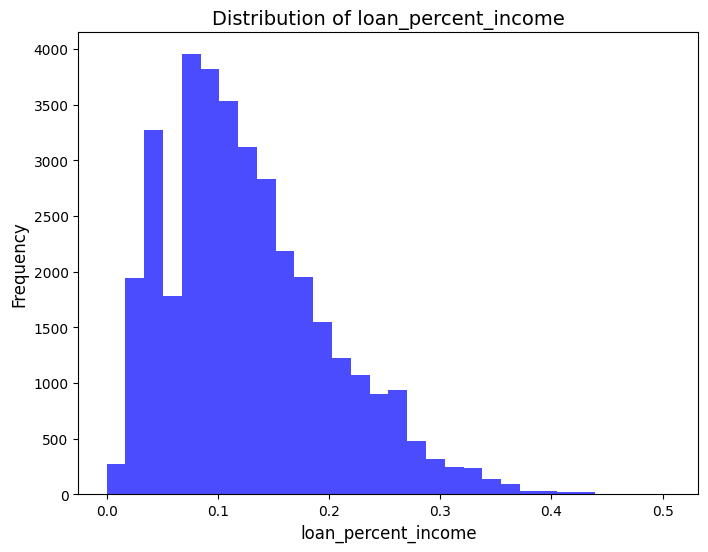

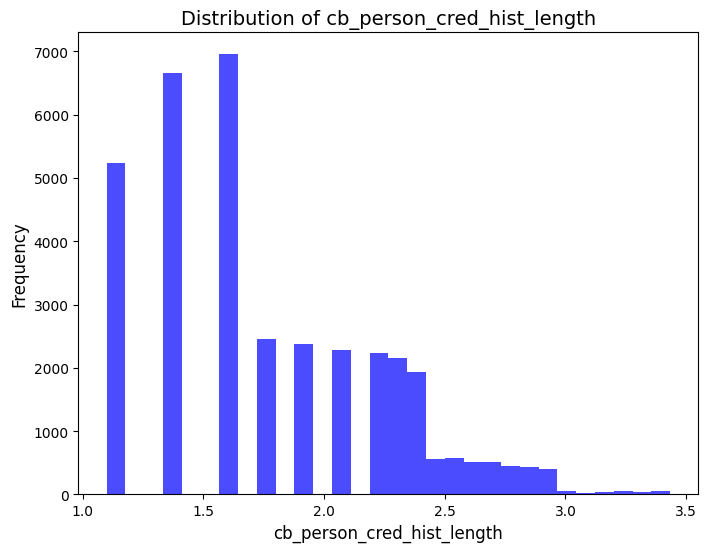

In [9]:
numerical_columns = find_numerical_cols(train_spark_df)
plot_distribution(train_spark_df, numerical_columns)



# Deal with correlation
- Using unsupervised method like Variance Threshold for Feature Selection

# Transforming categorical data

In [10]:
categorical_cols = find_categorical_cols(train_spark_df)

pipeline = onehot_encoding_pipeline(train_spark_df, categorical_cols)
train_spark_df = pipeline.transform(train_spark_df)
test_spark_df = pipeline.transform(test_spark_df)
val_spark_df = pipeline.transform(val_spark_df)

Drop not needed columns

In [11]:
columns_to_drop = categorical_cols + [col + "_index" for col in categorical_cols]
train_spark_df = train_spark_df.drop(*columns_to_drop)
test_spark_df = test_spark_df.drop(*columns_to_drop)
val_spark_df = val_spark_df.drop(*columns_to_drop)

In [ ]:
save_to_parquet(train_spark_df, str(PROJECT_DIR / "data" / "features" / "feature_engineering_1.h5"), key="train", mode="w")
save_to_parquet(test_spark_df, str(PROJECT_DIR / "data" / "features" / "feature_engineering_1.h5"), key="test")
save_to_parquet(val_spark_df, str(PROJECT_DIR / "data" / "features" / "feature_engineering_1.h5"), key="val")

/Users/haiduong/Documents/mlops-loan-approval-classification/train/transforms/utils.py:30: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['loan_status', 'person_gender_encoded', 'person_education_encoded',
       'person_home_ownership_encoded', 'loan_intent_encoded',
       'loan_int_rate_encoded', 'credit_score_encoded',
       'previous_loan_defaults_on_file_encoded'],
      dtype='object')]

  pandas_df.to_hdf(output_dir, key=key, mode='w')
/Users/haiduong/Documents/mlops-loan-approval-classification/train/transforms/utils.py:30: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['loan_status', 'person_gender_encoded', 'person_education_encoded',
       'person_home_ownership_encoded', 'loan_intent_encoded',
       'loan